Data Sourced From: https://moneypuck.com/data.htm

# Imports

In [111]:
import pandas as pd
import numpy as np
import glob
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# Read Data

In [112]:
df: pd.DataFrame = pd.concat(
    [pd.read_csv(csv_file) for csv_file in glob.glob('./Data/*.csv')],
    ignore_index=True
)

df.set_index('playerId', inplace=True)

# Feature Engineering

In [113]:
# remove 4on5, 5on5, etc. and just include aggregate stats of all situations
df = df[df['situation'] == 'all']

# only select columns which i believe are important (could change to RFC)
df = df[[
    'name', 'season', 'games_played', 'icetime',
    'onIce_xGoalsPercentage', 'I_F_primaryAssists', 'I_F_secondaryAssists',
    'I_F_points', 'I_F_goals', 'I_F_penalityMinutes', 'I_F_takeaways',
    'I_F_lowDangerGoals', 'I_F_mediumDangerGoals', 'I_F_highDangerGoals'
]]

In [114]:
# reformat selected feature names
df.columns = df.columns.str.replace('^I_F_', '', regex=True)

df = df.rename(columns={
    'games_played': 'gamesPlayed',
    'icetime': 'iceTime',
    'onIce_xGoalsPercentage': 'onIceGoalsPercentage',
    'penalityMinutes': 'penaltyMinutes'
})

In [115]:
# create a new points per game feature
df['pointsPerGame'] = round(df['points'] / df['gamesPlayed'], 3)

In [116]:
# create my target feature
df['isMvp'] = 0

# a dictionary of mvp winners
mvp_map: dict[int, str] = {
    2015: 'Patrick Kane',
    2016: 'Connor McDavid',
    2017: 'Taylor Hall',
    2018: 'Nikita Kucherov',
    2019: 'Leon Draisaitl',
    2020: 'Connor McDavid',
    2021: 'Auston Matthews',
    2022: 'Connor McDavid',
    2023: 'Nathan MacKinnon'
}

# go year-by-year and set the mvp
for year, player in mvp_map.items():
    df.loc[(df['name'] == player) & (df['season'] == year), 'isMvp'] = 1

# my target variable is 'isMvp' (it is HEAVILY imbalanced)
df[df['isMvp'] == 1].sort_values('season')

,name,season,gamesPlayed,iceTime,onIceGoalsPercentage,primaryAssists,secondaryAssists,points,goals,penaltyMinutes,takeaways,lowDangerGoals,mediumDangerGoals,highDangerGoals,pointsPerGame,isMvp
playerId,,,,,,,,,,,,,,,,
8474141,Patrick Kane,2015,82,100373.0,0.58,41.0,19.0,106.0,46.0,30.0,34.0,19.0,10.0,17.0,1.293,1
8478402,Connor McDavid,2016,81,102604.0,0.62,44.0,26.0,99.0,29.0,24.0,75.0,5.0,17.0,7.0,1.222,1
8475791,Taylor Hall,2017,76,87172.0,0.59,30.0,24.0,93.0,39.0,34.0,81.0,15.0,10.0,14.0,1.224,1
8476453,Nikita Kucherov,2018,82,98264.0,0.62,52.0,34.0,127.0,41.0,52.0,58.0,14.0,16.0,11.0,1.549,1
8477934,Leon Draisaitl,2019,71,96187.0,0.57,39.0,27.0,109.0,43.0,18.0,60.0,10.0,17.0,16.0,1.535,1
8478402,Connor McDavid,2020,56,74418.0,0.69,50.0,22.0,105.0,33.0,20.0,36.0,8.0,16.0,9.0,1.875,1
8479318,Auston Matthews,2021,73,90270.0,0.65,26.0,20.0,106.0,60.0,18.0,92.0,23.0,18.0,19.0,1.452,1
8478402,Connor McDavid,2022,82,110137.0,0.67,60.0,29.0,153.0,64.0,36.0,82.0,18.0,25.0,21.0,1.866,1
8477492,Nathan MacKinnon,2023,82,112246.0,0.65,50.0,39.0,140.0,51.0,32.0,42.0,14.0,24.0,13.0,1.707,1


In [117]:
# adjusting column data types to save memory
df = df.astype({
    'iceTime': int,
    'primaryAssists': int,
    'secondaryAssists': int,
    'points': int,
    'goals': int,
    'penaltyMinutes': int,
    'takeaways': int,
    'lowDangerGoals': int,
    'mediumDangerGoals': int,
    'highDangerGoals': int
})

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8255 entries, 8479595 to 8475176
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  8255 non-null   object 
 1   season                8255 non-null   int64  
 2   gamesPlayed           8255 non-null   int64  
 3   iceTime               8255 non-null   int64  
 4   onIceGoalsPercentage  8255 non-null   float64
 5   primaryAssists        8255 non-null   int64  
 6   secondaryAssists      8255 non-null   int64  
 7   points                8255 non-null   int64  
 8   goals                 8255 non-null   int64  
 9   penaltyMinutes        8255 non-null   int64  
 10  takeaways             8255 non-null   int64  
 11  lowDangerGoals        8255 non-null   int64  
 12  mediumDangerGoals     8255 non-null   int64  
 13  highDangerGoals       8255 non-null   int64  
 14  pointsPerGame         8255 non-null   float64
 15  isMvp            

# Data Visualization

In [118]:
print(f"{df.index.nunique()} total unique players")

1933 total unique players


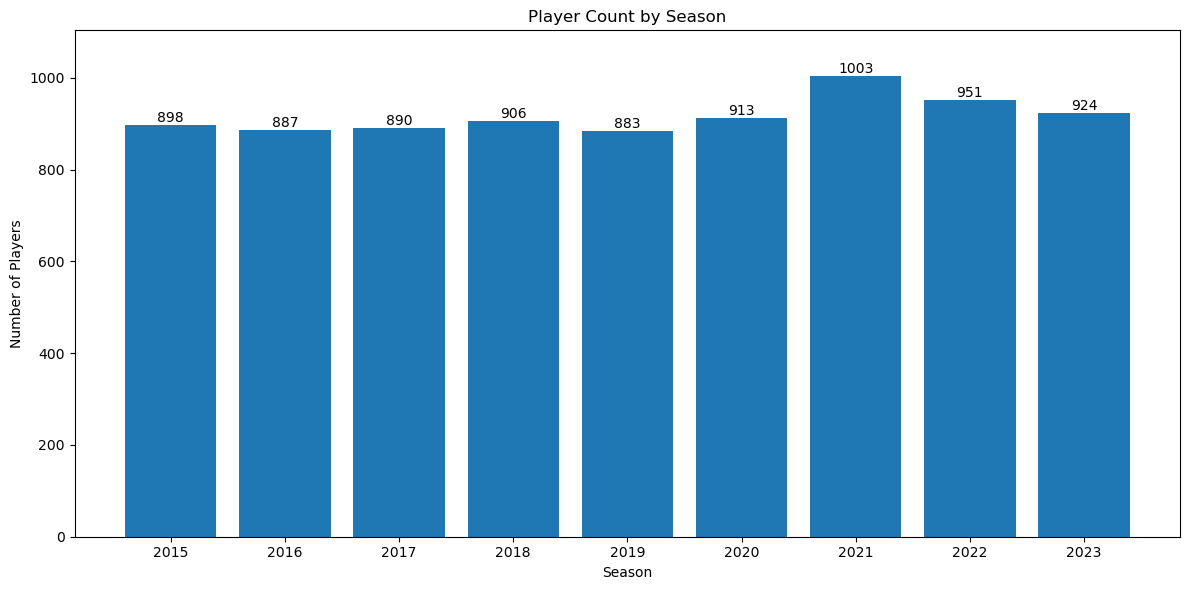

In [119]:
player_counts: pd.Series = df.groupby('season').size()

# construct the table
plt.figure(figsize=(12, 6))
plt.bar(player_counts.index, player_counts.values)
plt.title('Player Count by Season')
plt.xlabel('Season')
plt.ylabel('Number of Players')
plt.xticks(player_counts.index)

# show number of players above each bar
for idx, val in enumerate(player_counts.values):
    plt.text(player_counts.index[idx], val, str(val), ha='center', va='bottom')

plt.margins(y=0.1)
plt.tight_layout()
plt.show()

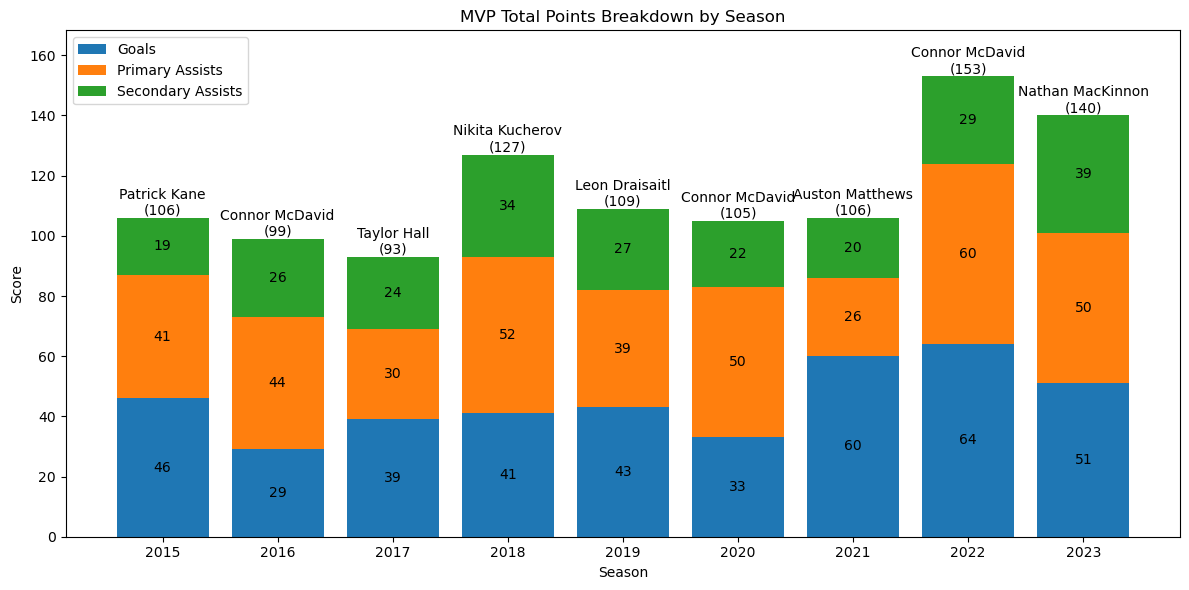

In [120]:
mvp_df: pd.DataFrame = df[df['isMvp'] == 1]

plt.figure(figsize=(12, 6))

# separate the goals, primary assists, and secondary assists into bars
goals_bars = plt.bar(
    mvp_df['season'],
    mvp_df['goals'],
    label='Goals'
)
primary_assists_bars = plt.bar(
    mvp_df['season'],
    mvp_df['primaryAssists'],
    bottom=mvp_df['goals'],
    label='Primary Assists'
)
secondary_assists_bars = plt.bar(
    mvp_df['season'],
    mvp_df['secondaryAssists'],
    bottom=mvp_df['goals']+mvp_df['primaryAssists'],
    label='Secondary Assists'
)

plt.title('MVP Total Points Breakdown by Season')
plt.xlabel('Season')
plt.ylabel('Score')
plt.xticks(mvp_df['season'])
plt.legend()

# add count labels in each section of each stacked bar
for bar in goals_bars:
    height: int = bar.get_height()
    plt.text(
        bar.get_x()+bar.get_width()/2, height/2,
        f'{int(height)}', ha='center', va='center'
    )

for bar in primary_assists_bars:
    height: int = bar.get_height()
    plt.text(
        bar.get_x()+bar.get_width()/2, bar.get_y()+height/2,
        f'{int(height)}', ha='center', va='center'
    )

for bar in secondary_assists_bars:
    height: int = bar.get_height()
    plt.text(
        bar.get_x()+bar.get_width()/2, bar.get_y()+height/2,
        f'{int(height)}', ha='center', va='center'
    )

# add total points labels to top of each bar
for idx, season in enumerate(mvp_df['season']):
    points: int = mvp_df[mvp_df['season'] == season]['points'].values[0]
    name: str = mvp_df[mvp_df['season'] == season]['name'].values[0]
    plt.text(season, points, f'{name}\n({points})', ha='center', va='bottom')


plt.margins(y=0.1)
plt.tight_layout()
plt.show()

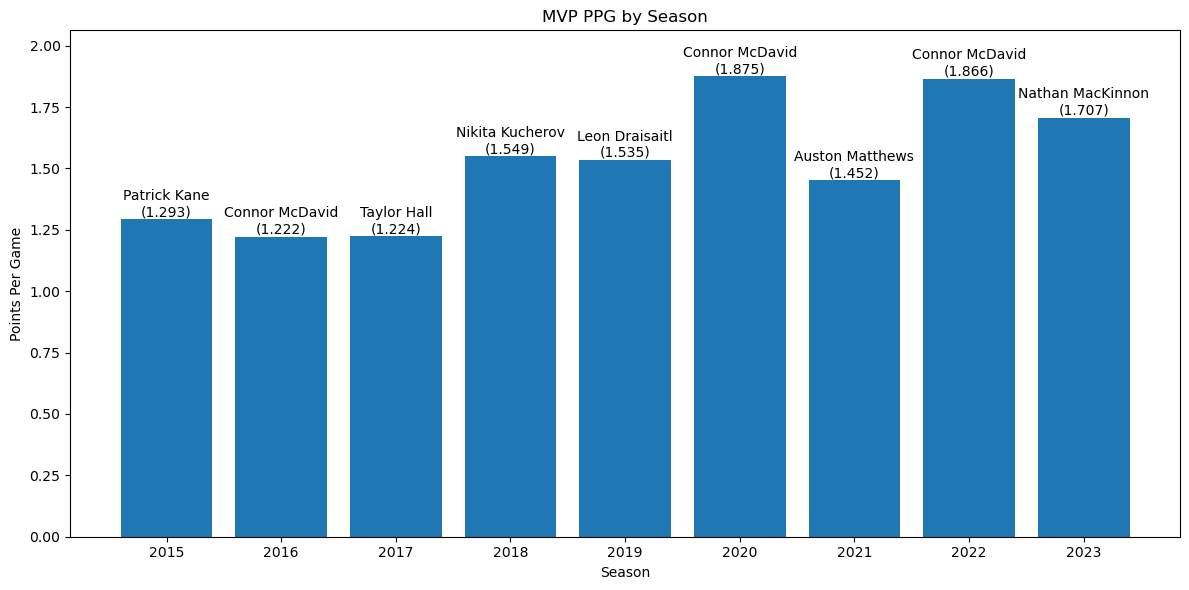

In [121]:
plt.figure(figsize=(12, 6))

# create the chart
bars = plt.bar(mvp_df['season'], mvp_df['pointsPerGame'])
plt.title('MVP PPG by Season')
plt.xlabel('Season')
plt.ylabel('Points Per Game')
plt.xticks(mvp_df['season'])

# apply top labels
for idx, season in enumerate(mvp_df['season']):
    ppg: float = mvp_df[mvp_df['season'] == season]['pointsPerGame'].values[0]
    name: str = mvp_df[mvp_df['season'] == season]['name'].values[0]
    plt.text(season, ppg, f'{name}\n({ppg})', ha='center', va='bottom')

plt.margins(y=0.1)
plt.tight_layout()
plt.show()

# Modeling

In [122]:
# splitting up training and testing data
# based on the season selected
# all data from before the selected season will be used to train

season: int = 2023

# after first pass at modeling, these features aren't valuable
# 'points' feature information is already included in other features
df = df.drop(columns=['points', 'iceTime', 'penaltyMinutes', 'takeaways'])

train_df: pd.DataFrame = df[df['season'] < season].copy()
test_df: pd.DataFrame = df[df['season'] == season].copy()

X_train: pd.DataFrame = train_df.drop(['isMvp', 'name', 'season'], axis=1)
y_train: pd.Series = train_df['isMvp']

X_test: pd.DataFrame = test_df.drop(['isMvp', 'name', 'season'], axis=1)

In [123]:
# set up and train the linear regression model
linear_regression_ml: LinearRegression = LinearRegression()
linear_regression_ml.fit(X_train, y_train)

# predict an mvp score/probability
y_pred: np.ndarray = linear_regression_ml.predict(X_test)

# test_df = test_df.copy()
test_df.loc[:, 'mvpProba'] = y_pred

# Results

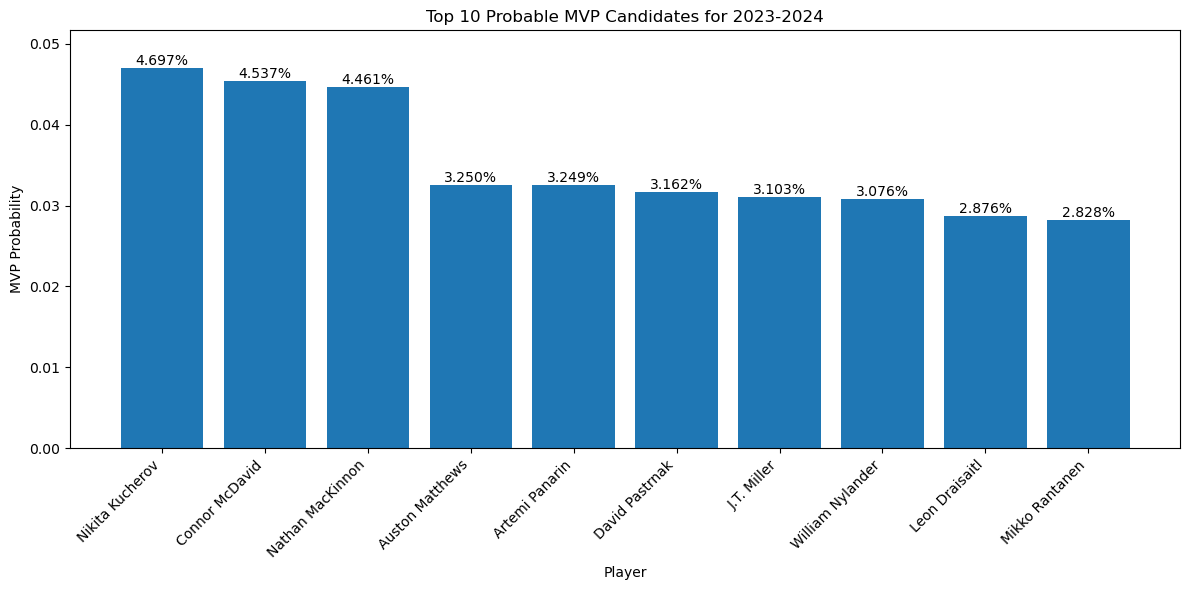

In [124]:
results_df = test_df[['name', 'mvpProba']].sort_values(
    'mvpProba', ascending=False
).head(10)

plt.figure(figsize=(12, 6))

bars = plt.bar(results_df['name'], results_df['mvpProba'])
plt.title(f"Top 10 Probable MVP Candidates for {season}-{season+1}")
plt.xlabel('Player')
plt.ylabel('MVP Probability')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2, bar.get_height(),
        f'{bar.get_height()*100:.3f}%', ha='center', va='bottom'
    )

plt.margins(y=0.1)
plt.tight_layout()
plt.show()

In [125]:
# mean squared error
y_train_pred = linear_regression_ml.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
print(f"\nTraining Mean Squared Error: {train_mse}")


Training Mean Squared Error: 0.0010527571249957135


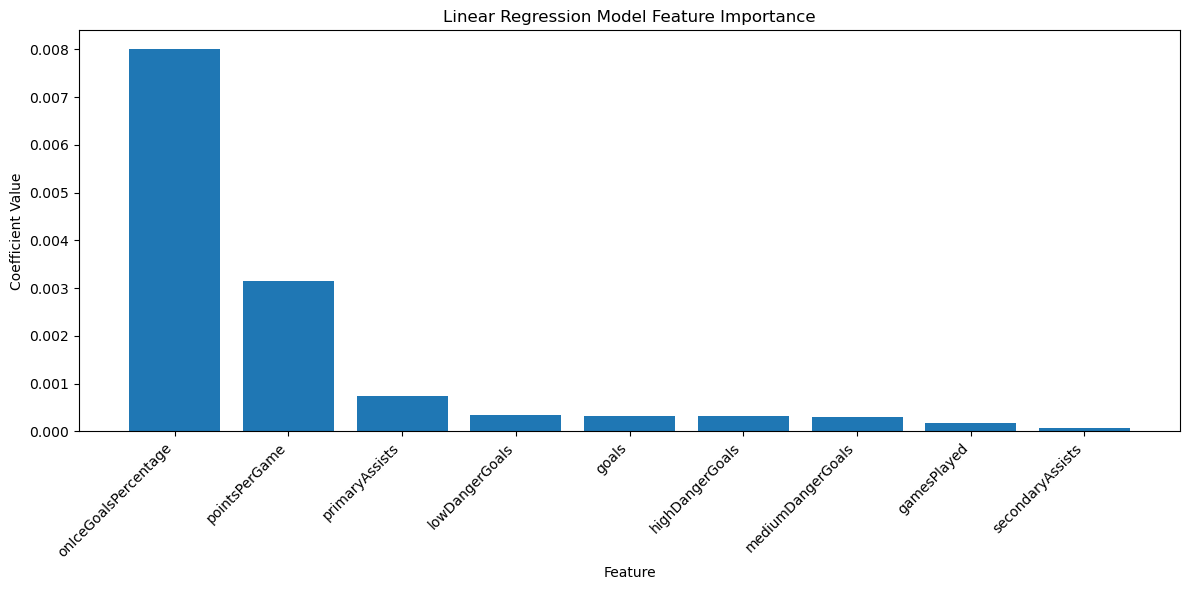

In [126]:
# creating a feature importance data frame
feature_importance: pd.DataFrame = pd.DataFrame({
    'feature': X_train.columns,
    'importance': abs(linear_regression_ml.coef_)
}).sort_values('importance', ascending=False)

# plotting the data
plt.figure(figsize=(12, 6))

plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Linear Regression Model Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()